# Processamento Estatístico de Sinais - TI 0124 - Trabalho Final (AP2)

## Prof. Charles Casimiro Cavalcante, Dr.
## Wireless Telecommunications Research Group - GTEL
## Department of Teleinformatics Engineering - DETI
## Federal University of Ceará (UFC) - Brazil
## URL: [charlescasimiro.github.io](https://charlescasimiro.github.io/)


## Alunos:

- Paulo Ricardo Menezes Soares - 537440
- Pedro Leinos Falcão Cunha - 542114
- Kelvin Leandro Martins - 540006


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

# Filtragem ótima e predição de sinais

Em várias aplicações práticas há uma necessidade de cancelar ruído que foi adicionado a um sinal. Por exemplo, se estamos usando o telefone celular dentro de um ruído e o ruído do carro ou rádio é adicionado à mensagem que estamos tentando transmitir. A Figura 1 ilustra as situações de contaminação de ruído

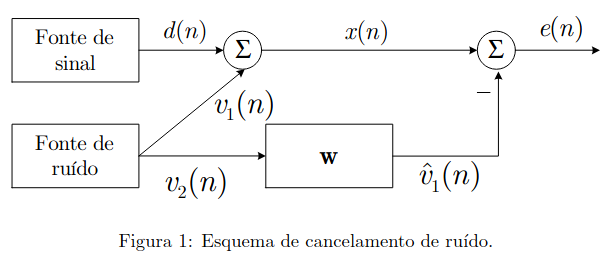

In [ ]:
! gdown 1bMuyDiNmoPBdX2kojNyenc8Adu03ffXz # conversation.mp3
! gdown 11j78eQHCuX7hxrPGu6GyiZPy-30gE30j # air_conditioner.mp3 => noise

Downloading...
From: https://drive.google.com/uc?id=1bMuyDiNmoPBdX2kojNyenc8Adu03ffXz
To: /content/conversation.mp3
100% 1.61M/1.61M [00:00<00:00, 32.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=11j78eQHCuX7hxrPGu6GyiZPy-30gE30j
To: /content/air_conditioner.mp3
100% 627k/627k [00:00<00:00, 18.4MB/s]


In [ ]:
! pip install pydub tqdm # ler audio e criar barra de progresso

## a) Calcule o filtro de Wiener (filtro ótimo) de tal configuração em relação às estatísticas dos sinais envolvidos que você dispõe (conhece)

In [ ]:
from tqdm import tqdm

def cross_correlation_matrix(signal1, signal2, P=None):
  """
  Calcula a matriz de correlação cruzada entre dois sinais.

  Params:
      signal1 (np.array): Primeiro signal.
      signal2 (np.array): Segundo sinal.
      P (int): Tamanho da matriz de correlação (P x P).

  Returns:
      np.array: Cross-correlation matrix of size (P x P).
  """
  if len(signal1) != len(signal2):
    raise ValueError("Sinais devem ter o mesmo comprimento.")

  N = len(signal1)

  if P is None:
    P = N
  elif P > N:
    raise ValueError("O valor de P deve ser menor ou igual ao comprimento dos sinais.")

  X = np.zeros((N + P - 1, P), dtype=np.float32)
  for i in range(P):
    X[i:i + N, i] = signal1

  Y = np.zeros((N + P - 1, P), dtype=np.float32)
  for i in range(P):
    Y[i:i + N, i] = signal2

  cross_corr_matrix = (1 / N) * X.T @ Y
  return cross_corr_matrix

def wiener_filter(input_signal, desired_signal):
  """
  Calcula o filtro de Wiener para um sinal de entrada e um sinal desejado.

  Params:
      input_signal (np.array): Sinal de entrada.
      desired_signal (np.array): Sinal desejado.

  Returns:
      np.array: Filtro de Wiener.
  """

  auto_corr = cross_correlation_matrix(input_signal, input_signal)
  cross_corr = cross_correlation_matrix(input_signal, desired_signal)

  w_opt = np.linalg.inv(auto_corr) @ cross_corr
  return w_opt

def wiener_in_batches(input_signal, desired_signal, batch_size=1000):
  """
  Aplica o efeito de 'cancelamento de ruído' utilizando filtro de Wiener dado um
  sinal de entrada e um sinal desejado processando em batches. Eficiente para
  sinais com taxa de amostragem alta.

  Params:
      input_signal (np.array): Sinal de entrada
      desired_signal (np.array): Sinal de entrada
      batch_size (int): Tamanho do batch

  Returns:
      np.array: Sinal de entrada após o efeito do cancelamento de ruído
  """
  n_batches = len(input_signal) // batch_size

  for i in tqdm(range(n_batches), desc="Processing batches"):
    end_batch = min((i + 1) * batch_size, len(input_signal))
    input_batch = input_signal[i * batch_size:end_batch]
    desired_batch = desired_signal[i * batch_size:end_batch]
    w_opt = wiener_filter(input_batch, desired_batch)

    if i == 0:
      approx = input_batch @ w_opt
    else:
      approx = np.concatenate((approx, input_batch @ w_opt))

  return approx

## (b) Mostre uma simulação do processo de cancelamento de ruído, usando sinais de áudio, contaminados por ruído, por exemplo.

In [ ]:
np.random.seed(0)
n = 1000
t = np.linspace(0, 1, n)
s = np.sin(2 * np.pi * 5 * t)  # Sinal original
v = 0.5 * np.random.normal(size=n)  # Ruido
x = s + v  # Sinal ruidoso

w_opt = wiener_filter(x, s)
approx = x @ w_opt

In [ ]:
# tentando com audio real
from pydub import AudioSegment

conversation_audio = AudioSegment.from_mp3("conversation.mp3").set_channels(1)
noise_audio = AudioSegment.from_mp3("air_conditioner.mp3").set_channels(1)

print("Detalhes do audio da conversa:")
print(f"Duração: {conversation_audio.duration_seconds:.1f} s")
print('-'*30)
print("Detalhes do ruido:")
print(f"Duração: {noise_audio.duration_seconds:.1f} s")
print('-'*30)

# fazendo terem a mesma duração
length = 10 * 1000
conversation_audio = conversation_audio[:length]
noise_audio = noise_audio[:length] - 10

conversation_audio.export("short_conversation.mp3", format='mp3')

# juntando os dois audios
input_audio = conversation_audio.overlay(noise_audio)
input_audio.export("input.mp3", format="mp3")

conversation_signal = np.array(conversation_audio.get_array_of_samples(), dtype=np.float32)
noise_signal = np.array(noise_audio.get_array_of_samples(), np.float32)
input_signal = np.array(input_audio.get_array_of_samples(), np.float32)

print(f"Duração final: {input_audio.duration_seconds:.1f} s")
print(f"No. amostras: {len(input_signal):,}")
print(f"Frame rate: {input_audio.frame_rate} Hz")

Detalhes do audio da conversa:
Duração: 100.3 s
------------------------------
Detalhes do ruido:
Duração: 39.1 s
------------------------------
Duração final: 10.0 s
No. amostras: 441,000
Frame rate: 44100 Hz


In [ ]:
Audio(data=conversation_signal, rate=conversation_audio.frame_rate)

In [ ]:
Audio(data=noise_signal, rate=noise_audio.frame_rate)

In [ ]:
Audio(data=input_signal, rate=input_audio.frame_rate)

In [ ]:
from scipy.io.wavfile import write

batch_size = input_audio.frame_rate // 8 # a cada 0.25s
# vai demorar
output_anc = wiener_in_batches(input_signal, conversation_signal, batch_size=batch_size)

Audio(data=output_anc, rate=input_audio.frame_rate)

## c) Mostre os dois sinais (sem ruído cancelado e com ruído cancelado) para comparar os ganhos.

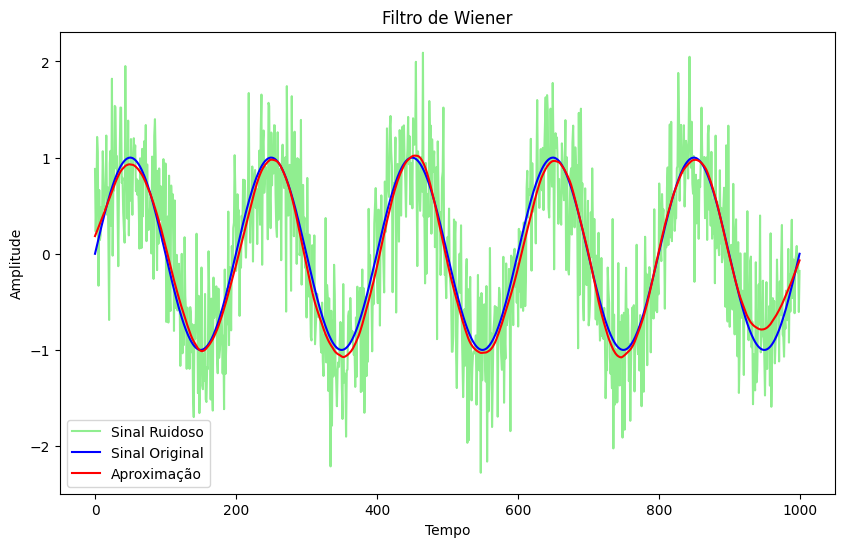

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(x, label='Sinal Ruidoso', c='lightgreen')
plt.plot(s, label='Sinal Original', c='b')
plt.plot(approx, label='Aproximação', c='r')
plt.xlabel('Tempo')
plt.ylabel('Amplitude')
plt.title('Filtro de Wiener')
plt.legend()
plt.show()

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(12, 10))

axs[0].plot(input_signal, label='sinal com ruido', c='lightred')
axs[0].plot(conversation_signal, label='sinal original', c='blue')
axs[0].set_title('Comparação audio original e ruidoso')
axs[0].set_xlabel('Tempo')
axs[0].legend()

axs[1].plot(input_signal, label='sinal com ruido', c='lightred')
axs[1].plot(approx, label='sinal filtrado', c='blue')
axs[1].set_title('Resultado do cancelamento de ruído')
axs[1].set_xlabel('Tempo')
axs[1].legend()

axs[2].plot(conversation_signal, label='sinal original')
axs[2].plot(approx, label='sinal filtrado')
axs[2].set_title('Comparação audio original e filtrado')
axs[2].set_xlabel('Tempo')
axs[2].legend()

plt.tight_layout()
plt.show()

# Teoria da Detecção

Um sistema de comunicação binário transmite sinais com valores -1 e +1 sob as hipóteses $H_0$ e $H_1$, respectivamente. O sinal recebido é corrompido por um ruído gaussiano de média nula e variância unitária. Calcule a regra de decisão ótima para obter a **taxa de probabilidade mínima**.

Sendo o dado recebido dado no arquivo [Recebido.txt](https://www.dropbox.com/scl/fi/k5aqmaq0oblcf8km9coth/Recebido.txt?rlkey=kw5ibymd24vsfg2kvmpgex3gg&dl=0) e o sinal transmitido, disponível em [Transmitido.txt](https://www.dropbox.com/scl/fi/s5f49pptwmeniwyikqvm4/Transmitido.txt?rlkey=w3ue2ps9u379b8y48hrw5lze2&e=1&dl=0), calcule a probabilidade de erro nas amostras dadas.

Mostre a distribuição das amostras do sinal recebido, mostrando o liminar/região de decisão.

In [ ]:
! wget -O Recebido.txt "https://www.dropbox.com/scl/fi/k5aqmaq0oblcf8km9coth/Recebido.txt?rlkey=kw5ibymd24vsfg2kvmpgex3gg&dl=1"
! wget -O Transmitido.txt "https://www.dropbox.com/scl/fi/s5f49pptwmeniwyikqvm4/Transmitido.txt?rlkey=w3ue2ps9u379b8y48hrw5lze2&e=1&dl=1"

--2025-02-01 19:13:34--  https://www.dropbox.com/scl/fi/k5aqmaq0oblcf8km9coth/Recebido.txt?rlkey=kw5ibymd24vsfg2kvmpgex3gg&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc93ee97355b98d8c803923eb511.dl.dropboxusercontent.com/cd/0/inline/CjWmT6VZpMJHK3Ha004FbxnT2OgCLlgNkRmMnpYsX8KSs80Mcqa_h-6vGR2dMuQ_bbSMO2LjNF1aZmRTMNMdktmfpbj9nxU0JO6N4K7a0T23-uxUaHr7cHEe3y6-RU9vUdA/file?dl=1# [following]
--2025-02-01 19:13:35--  https://uc93ee97355b98d8c803923eb511.dl.dropboxusercontent.com/cd/0/inline/CjWmT6VZpMJHK3Ha004FbxnT2OgCLlgNkRmMnpYsX8KSs80Mcqa_h-6vGR2dMuQ_bbSMO2LjNF1aZmRTMNMdktmfpbj9nxU0JO6N4K7a0T23-uxUaHr7cHEe3y6-RU9vUdA/file?dl=1
Resolving uc93ee97355b98d8c803923eb511.dl.dropboxusercontent.com (uc93ee97355b98d8c803923eb511.dl.dropboxusercontent.com)... 162.125.5.15, 2620:100:601d:15::a27d:50f
Connec

Probabilidade de erro: 0.1536


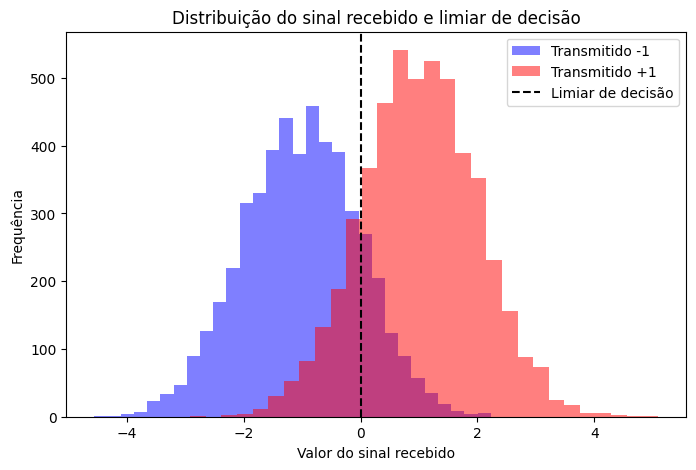

In [ ]:
recebido = np.loadtxt('Recebido.txt')
transmitido = np.loadtxt('Transmitido.txt')

# Regra de decisão ótima: Se recebido >= 0, decidir +1; caso contrário, decidir -1
decisao = np.where(recebido >= 0, 1, -1)

erro = decisao != transmitido
probabilidade_erro = np.mean(erro)
print(f"Probabilidade de erro: {probabilidade_erro:.4f}")

plt.figure(figsize=(8, 5))
plt.hist(recebido[transmitido == -1], bins=30, alpha=0.5, label="Transmitido -1", color="blue")
plt.hist(recebido[transmitido == 1], bins=30, alpha=0.5, label="Transmitido +1", color="red")
plt.axvline(0, color="black", linestyle="--", label="Limiar de decisão")
plt.xlabel("Valor do sinal recebido")
plt.ylabel("Frequência")
plt.legend()
plt.title("Distribuição do sinal recebido e limiar de decisão")
plt.show()

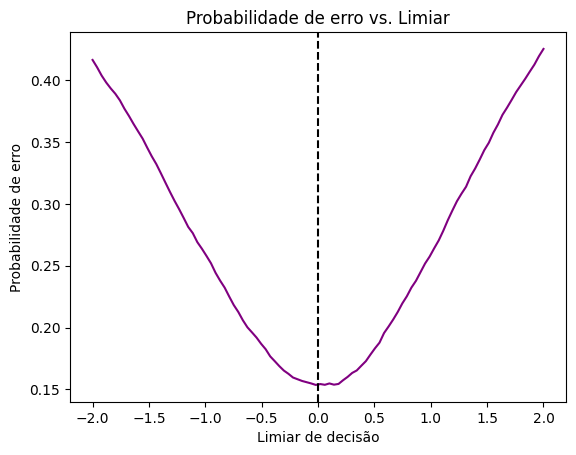

In [ ]:
# probabilidade de erro para diferentes limiares
limiares = np.linspace(-2, 2, 100)
prob_erros = []

for limiar in limiares:
    decisao_var = np.where(recebido >= limiar, 1, -1)
    erro_var = decisao_var != transmitido
    prob_erros.append(np.mean(erro_var))

plt.plot(limiares, prob_erros, color="purple")
plt.axvline(0, color="black", linestyle="--", label="Limiar ótimo (0)")
plt.xlabel("Limiar de decisão")
plt.ylabel("Probabilidade de erro")
plt.title("Probabilidade de erro vs. Limiar")
plt.show()

# Algoritmos recursivos

Considere um sinal branco gaussiano de variância unitária transmitido por um canal de comunicação de função de transferência $H(z) = 1 + 1.6z^{-1}$. Para compensar este canal utiliza-se um equalizador dado por $ W(z) = w_0 + w_1z^{-1} $. Forneça o equalizador ótimo segundo o critério de Wiener.

## a) Obtenha as trajetórias sobre as curvas de nível, tendo condições iniciais nulas para os coeficientes do equalizador, para os seguintes algoritmos

1. Gradiente determinístico;
2. Algoritmo de Newton;
3. LMS;
4. LMS-normalizado;

- Gradiente determinístico: $\mathbf{w}(n+1) = \mathbf{w}(n) - 2\mu[\mathbf{R_xw}(n) - \mathbf{p}_{xd}]$
- Algoritmo de Newton: $\mathbf{w}(n+1) = \mathbf{w}(n) - \mu[\mathbf{w}(n) - \mathbf{R_x}^{-1} \mathbf{p}_{xd}]$ (suponha $\mu = 1$ e $\mathbf{w}(0) = 0$, temos a solução ótima em uma iteração)
- Algoritmo LMS: $\mathbf{w}(n+1) = \mathbf{w}(n) + 2\mu\mathbf{x}(x)e(n)$
- Algoritmo LMS-normalizado: $\mathbf{w}(n+1) = \mathbf{w}(n) + \frac{\mu}{\lambda + \mathbf{x}^T(n)\mathbf{x}(n)}\mathbf{x}(x)e(n)$

## (b) Mostre a evolução temporal do erro de equalização para cada um dos critérios acima.

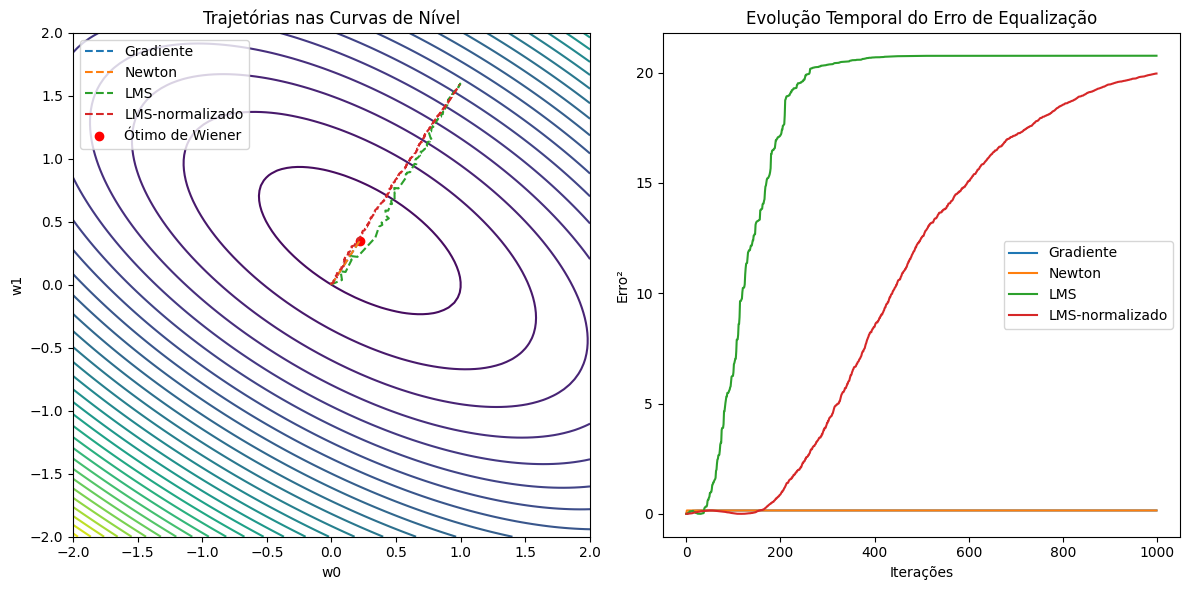

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_signal(num_samples, sigma2):
    """
    Gera o sinal transmitido (sinal branco gaussiano) e o recebido.

    Parameters:
        num_samples (int): Número de amostras do sinal.
        sigma2 (float): Variância do ruído.

    Returns:
        tuple: (s, r, h)
            s (numpy.ndarray): Sinal transmitido.
            r (numpy.ndarray): Sinal recebido após o canal.
            h (numpy.ndarray): Coeficientes do canal H(z).
    """
    s = np.random.normal(0, np.sqrt(sigma2), num_samples)
    h = np.array([1, 1.6])  # Coeficientes do canal H(z)
    r = np.convolve(s, h, mode='same')
    return s, r, h

def calculate_wiener(h, sigma2):
    """
    Calcula os coeficientes ótimos de Wiener.

    Parameters:
        h (numpy.ndarray): Coeficientes do canal H(z).
        sigma2 (float): Variância do ruído.

    Returns:
        tuple: (R, p, w_opt)
            R (numpy.ndarray): Matriz de autocorrelação do canal.
            p (numpy.ndarray): Vetor de correlação cruzada.
            w_opt (numpy.ndarray): Coeficientes ótimos de Wiener.
    """
    R = np.array([[sigma2 + h[0]**2, h[0] * h[1]], [h[0] * h[1], sigma2 + h[1]**2]])
    p = np.array([h[0], h[1]]) * sigma2
    w_opt = np.linalg.solve(R, p)
    return R, p, w_opt

def error(w0, w1, R, p):
    """
    Calcula o erro de equalização.

    Parameters:
        w0 (float): Coeficiente w0.
        w1 (float): Coeficiente w1.
        R (numpy.ndarray): Matriz de autocorrelação do canal.
        p (numpy.ndarray): Vetor de correlação cruzada.

    Returns:
        float: Erro de equalização.
    """
    w = np.array([w0, w1])
    return 0.5 * (np.dot(w, np.dot(R, w)) - 2 * np.dot(p, w))

def error_grid(W0, W1, R, p):
    """
    Gera uma grade de erros para curvas de nível.

    Parameters:
        W0 (numpy.ndarray): Grade de valores para w0.
        W1 (numpy.ndarray): Grade de valores para w1.
        R (numpy.ndarray): Matriz de autocorrelação do canal.
        p (numpy.ndarray): Vetor de correlação cruzada.

    Returns:
        numpy.ndarray: Grade de erros para as combinações de W0 e W1.
    """
    Z = np.zeros_like(W0)
    for i in range(W0.shape[0]):
        for j in range(W0.shape[1]):
            Z[i, j] = error(W0[i, j], W1[i, j], R, p)
    return Z

def gradient_descent(R, p, learning_rate, iterations):
    """
    Implementa o algoritmo de Gradiente Determinístico.

    Parameters:
        R (numpy.ndarray): Matriz de autocorrelação do canal.
        p (numpy.ndarray): Vetor de correlação cruzada.
        learning_rate (float): Taxa de aprendizado.
        iterations (int): Número de iterações.

    Returns:
        numpy.ndarray: Trajetória dos coeficientes ao longo das iterações.
    """
    w = np.zeros((iterations, 2))
    for i in range(1, iterations):
        grad = 2 * (np.dot(R, w[i-1]) - p)
        w[i] = w[i-1] - learning_rate * grad
    return w

def newton_method(R, p, iterations):
    """
    Implementa o algoritmo de Newton.

    Parameters:
        R (numpy.ndarray): Matriz de autocorrelação do canal.
        p (numpy.ndarray): Vetor de correlação cruzada.
        iterations (int): Número de iterações.

    Returns:
        numpy.ndarray: Trajetória dos coeficientes ao longo das iterações.
    """
    w = np.zeros((iterations, 2))
    w[1] = np.dot(np.linalg.inv(R), p)  # Solução ótima em uma iteração
    for i in range(2, iterations):
        w[i] = w[i-1]  # Newton converge em uma iteração
    return w

def lms(s, r, learning_rate, iterations):
    """
    Implementa o algoritmo LMS.

    Parameters:
        s (numpy.ndarray): Sinal transmitido.
        r (numpy.ndarray): Sinal recebido.
        learning_rate (float): Taxa de aprendizado.
        iterations (int): Número de iterações.

    Returns:
        numpy.ndarray: Trajetória dos coeficientes ao longo das iterações.
    """
    w = np.zeros((iterations, 2))
    for i in range(1, iterations):
        x = np.array([s[i], s[i-1]]) if i > 0 else np.array([0, 0])
        e = r[i] - np.dot(w[i-1], x)
        w[i] = w[i-1] + 2 * learning_rate * e * x
    return w

def lms_normalized(s, r, learning_rate, iterations, lambda_reg=1e-15):
    """
    Implementa o algoritmo LMS-normalizado.

    Parameters:
        s (numpy.ndarray): Sinal transmitido.
        r (numpy.ndarray): Sinal recebido.
        learning_rate (float): Taxa de aprendizado.
        iterations (int): Número de iterações.
        lambda_reg (float): Termo de regularização para evitar divisão por zero.

    Returns:
        numpy.ndarray: Trajetória dos coeficientes ao longo das iterações.
    """
    w = np.zeros((iterations, 2))
    for i in range(1, iterations):
        x = np.array([s[i], s[i-1]]) if i > 0 else np.array([0, 0])
        norm = lambda_reg + np.dot(x, x)
        e = r[i] - np.dot(w[i-1], x)
        w[i] = w[i-1] + (learning_rate / norm) * e * x
    return w

def plot_results(R, p, w_opt, w_gd, w_newton, w_lms, w_lms_n):
    """
    Gera os gráficos das trajetórias e evolução do erro.

    Parameters:
        R (numpy.ndarray): Matriz de autocorrelação do canal.
        p (numpy.ndarray): Vetor de correlação cruzada.
        w_opt (numpy.ndarray): Coeficientes ótimos de Wiener.
        w_gd (numpy.ndarray): Trajetória do Gradiente Determinístico.
        w_newton (numpy.ndarray): Trajetória do Algoritmo de Newton.
        w_lms (numpy.ndarray): Trajetória do LMS.
        w_lms_n (numpy.ndarray): Trajetória do LMS-normalizado.

    Returns:
        None
    """
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # (a) Trajetórias nas curvas de nível
    x = np.linspace(-2, 2, 100)
    y = np.linspace(-2, 2, 100)
    X, Y = np.meshgrid(x, y)
    Z = error_grid(X, Y, R, p)

    ax[0].contour(X, Y, Z, levels=30, cmap="viridis")
    ax[0].plot(w_gd[:, 0], w_gd[:, 1], label="Gradiente", linestyle="--")
    ax[0].plot(w_newton[:, 0], w_newton[:, 1], label="Newton", linestyle="--")
    ax[0].plot(w_lms[:, 0], w_lms[:, 1], label="LMS", linestyle="--")
    ax[0].plot(w_lms_n[:, 0], w_lms_n[:, 1], label="LMS-normalizado", linestyle="--")
    ax[0].scatter(*w_opt, color="red", label="Ótimo de Wiener")
    ax[0].set_title("Trajetórias nas Curvas de Nível")
    ax[0].set_xlabel("w0")
    ax[0].set_ylabel("w1")
    ax[0].legend()

    # (b) Evolução temporal do erro de equalização
    errors = {
        "Gradiente": [error(w[0], w[1], R, p) for w in w_gd],
        "Newton": [error(w[0], w[1], R, p) for w in w_newton],
        "LMS": [error(w[0], w[1], R, p) for w in w_lms],
        "LMS-normalizado": [error(w[0], w[1], R, p) for w in w_lms_n],
    }

    for key, value in errors.items():
        ax[1].plot(value, label=key)

    ax[1].set_title("Evolução Temporal do Erro de Equalização")
    ax[1].set_xlabel("Iterações")
    ax[1].set_ylabel("Erro²")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

# Configurações iniciais
np.random.seed(42)
num_samples = 1000
sigma2 = 1
learning_rate = 0.01
iterations = 1000

# Execução
s, r, h = generate_signal(num_samples, sigma2)
R, p, w_opt = calculate_wiener(h, sigma2)

w_gd = gradient_descent(R, p, learning_rate, iterations)
w_newton = newton_method(R, p, iterations)
w_lms = lms(s, r, learning_rate, iterations)
w_lms_n = lms_normalized(s, r, learning_rate, iterations)

plot_results(R, p, w_opt, w_gd, w_newton, w_lms, w_lms_n)